In [2]:


from pathlib import Path
from tqdm import tqdm


from transformers import TrainingArguments
from transformers import GPT2Config
from transformers import GPT2LMHeadModel, GPT2ForQuestionAnswering,GPT2Tokenizer
from transformers import AutoTokenizer
from transformers import DataCollatorForLanguageModeling
import tokenizers
import argparse 
from transformers import Trainer
import pandas as pd
from torch import nn, multinomial
import torch
from datasets import Dataset
from functools import partial
import os

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import Saliency
from numpy import random


/home/prabakaran/miniconda3/envs/train_2_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2ForQuestionAnswering.from_pretrained("gpt2")

Some weights of GPT2ForQuestionAnswering were not initialized from the model checkpoint at gpt2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
tokenizer.get_vocab()

tokenizer.vocab_size

50257

In [10]:
def ask_question(question):
    input_text = f"Question: {question}"
    output_text = " Justement je ne sais pas"
    input = tokenizer(
            input_text,output_text, return_tensors="pt"
        )
    

    with torch.no_grad():
        
        output = model(**input)
        print(output)

    answer_start_index = output.start_logits.argmax()
    answer_end_index = output.end_logits.argmax()
    predict_answer_tokens = input.input_ids[0, answer_start_index : answer_end_index + 1]

    answer = tokenizer.decode(predict_answer_tokens, skip_special_tokens=True)

    
    return answer

In [11]:
ask_question("What is a giraffe?")

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-2.0686, -5.7139, -5.4760, -3.7558, -3.9012, -5.1567, -3.9040, -4.7090,
         -6.4274, -4.3686, -5.3010, -5.1308, -4.5256, -4.1125, -4.1742]]), end_logits=tensor([[1.2822, 2.8289, 1.0064, 0.5596, 1.4225, 2.9197, 1.5080, 2.1928, 2.5962,
         2.3530, 2.7260, 2.6130, 2.5685, 2.0082, 1.8711]]), hidden_states=None, attentions=None)


'Question: What is a gir'

In [2]:
tokenizer_moses_can = AutoTokenizer.from_pretrained("../data/tokenizers/moses_canonical_corrected")

tokenizer_moses_can.model_max_length = 2 *tokenizer_moses_can.model_max_length 

In [3]:
def tokenize_func(examples, tokenizer,max_length):
    smiles = examples["SMILES"]
    scaffolds= examples["MURCKO_SCAFFOLDS_SMILES"]
    
    return tokenizer(
        smiles, scaffolds,
        padding="max_length", 
        max_length=max_length
    )



In [4]:
moses_canonical = pd.read_csv("../data/training_data/moses_canonical.csv")

def isstr(ex):
    return isinstance(ex, str)

In [5]:
import math

In [73]:
eval_set = moses_canonical[moses_canonical['SPLIT']=='test']
print(len(eval_set["SMILES"]))

eval_set = eval_set[eval_set["MURCKO_SCAFFOLDS_SMILES"]!=math.nan]
print(len(eval_set["SMILES"]))

176074
176074


In [10]:
smiles = "CCNNCC"*1000
scaffolds = "cccc"

aa = tokenizer_moses_can(
        smiles, scaffolds,
        padding="max_length", 
        max_length=124)
aa["input_ids"][2000:]

[133, 1, 140, 1]

In [74]:
eval_set = moses_canonical[moses_canonical['SPLIT']=='test']
eval_set["isstr"] = eval_set['MURCKO_SCAFFOLDS_SMILES'].apply(isstr)


print(len(eval_set["SMILES"]))
eval_set = eval_set[ eval_set['isstr']]
print(type(eval_set["MURCKO_SCAFFOLDS_SMILES"]))
print(len(eval_set["SMILES"]))

eval_set = Dataset.from_pandas(eval_set)

176074
<class 'pandas.core.series.Series'>
175984


/tmp/ipykernel_561313/1154506447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_set["isstr"] = eval_set['MURCKO_SCAFFOLDS_SMILES'].apply(isstr)


In [49]:
print(eval_set)

Dataset({
    features: ['Unnamed: 0', 'SPLIT', 'MURCKO_SCAFFOLDS_SMILES', 'SMILES', 'isstr', '__index_level_0__'],
    num_rows: 175984
})


In [ ]:
encoded_eval_set = eval_set.map(partial(tokenize_func, tokenizer=tokenizer_moses_can, max_length=tokenizer_moses_can.model_max_length), batched=True, remove_columns=eval_set.column_names)

Map: 100%|██████████| 175984/175984 [00:39<00:00, 4467.29 examples/s]


In [11]:
encoded_eval_set["input_ids"][0]

NameError: name 'encoded_eval_set' is not defined

In [28]:
smiles = "CCNNCC"
scaffolds = "cccc"
L1 = moses_canonical["MURCKO_SCAFFOLDS_SMILES"].to_list()
L2 = moses_canonical["SMILES"].to_list()
for i in range(len(L1)):
    exemple= tokenizer_moses_can(L2[i],L1[i])
    print(exemple)
#print(tokenizer_moses_can.decode(exemple))

{'input_ids': [0, 108, 106, 349, 5825, 174, 2030, 1, 4552, 1458, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 341, 60, 1162, 1467, 2385, 1, 467, 7989, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 90, 184, 555, 225, 9646, 526, 1, 417, 3184, 67, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 3084, 8208, 975, 468, 79, 1, 5283, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 191, 514, 1769, 427, 1038, 6726, 1, 3365, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 2870, 1151, 7157, 1038, 1324, 1, 1541, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_id

KeyboardInterrupt: 

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
def saliency_map_plot(scores,tokens,pred_token):    
    fig, ax = plt.subplots(figsize=(20, 1))

    im = ax.imshow([scores.tolist()],cmap="viridis", data=tokens)
    ax.set_title('saliency map')
    fig.colorbar(im)

    plt.xticks([k for k in range(len(scores.tolist()))], tokens)

    ax.set_xlabel("saliency map for this token prediction : "+pred_token)



/tmp/ipykernel_731101/2187636953.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(20, 1))


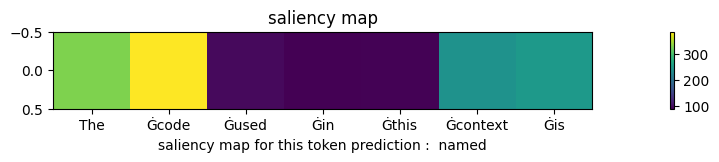

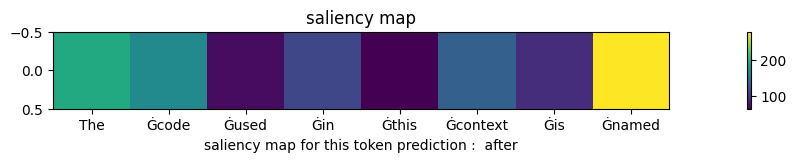

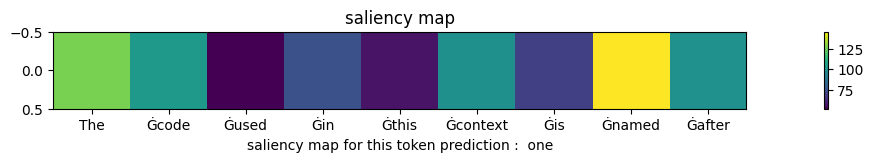

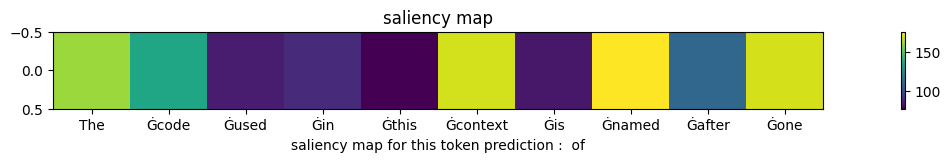

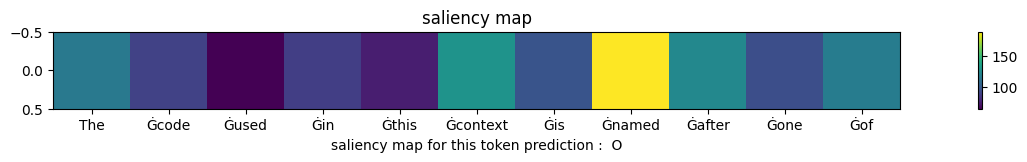

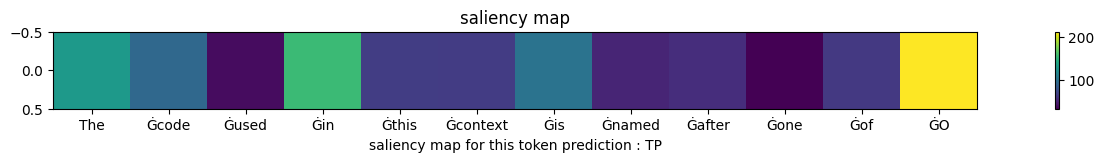

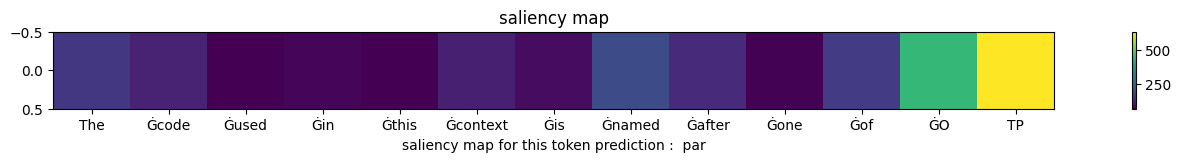

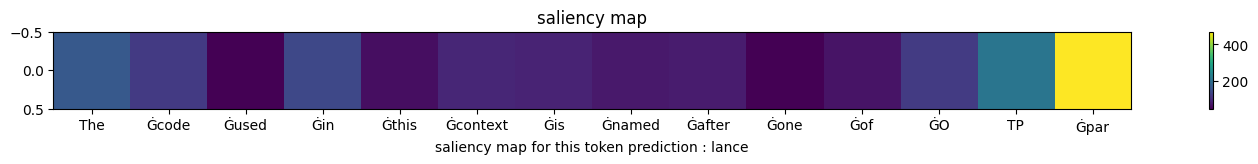

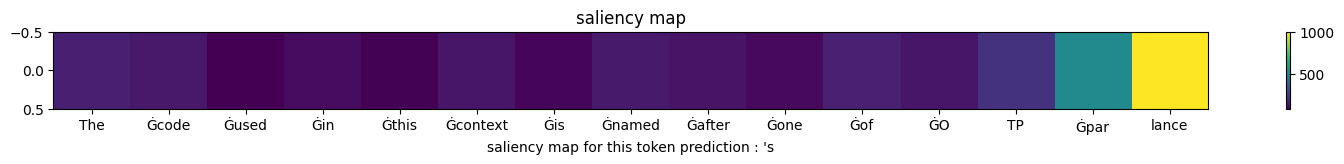

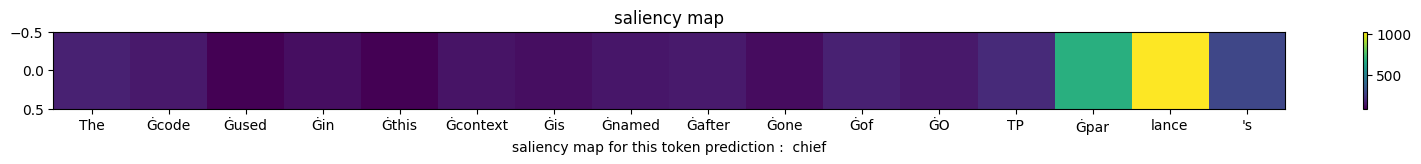

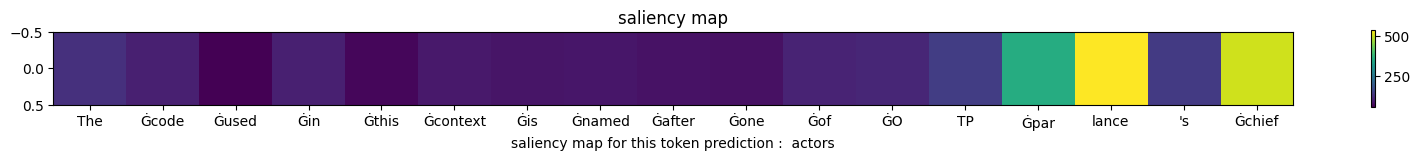

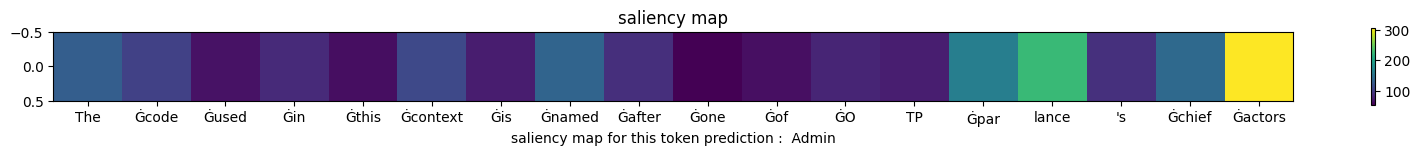

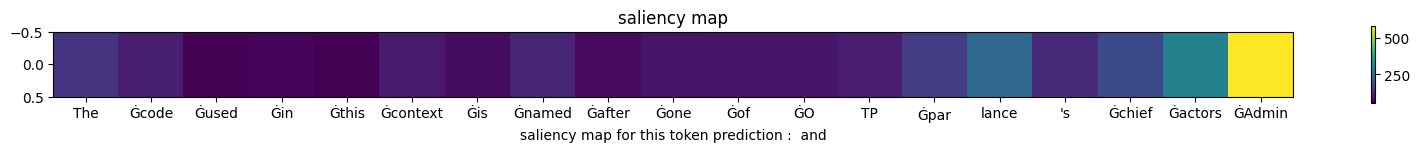

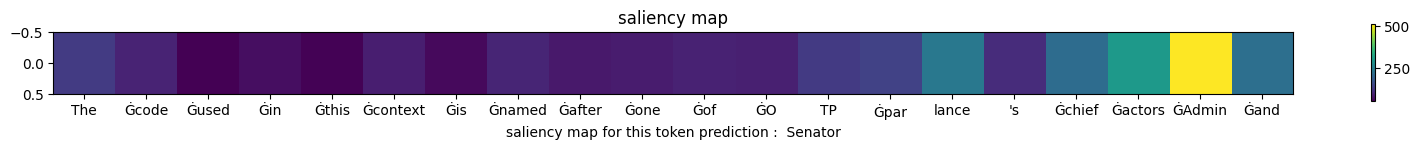

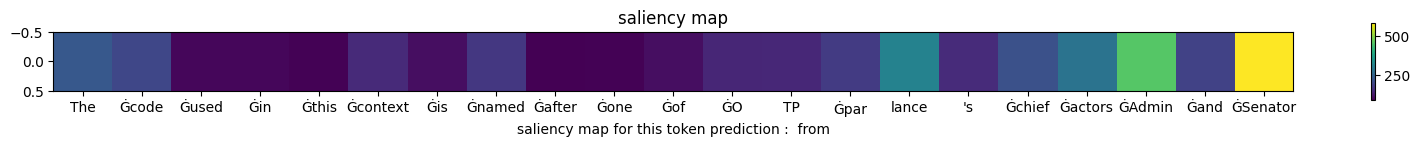

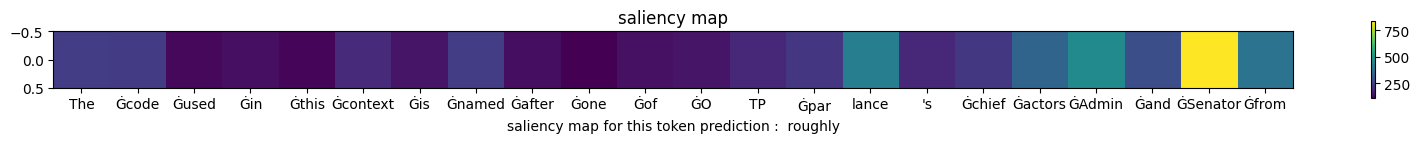

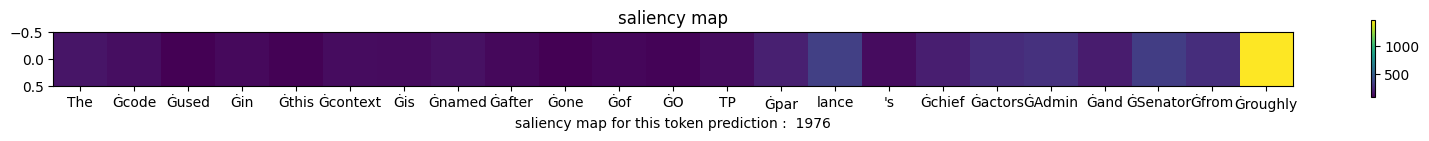

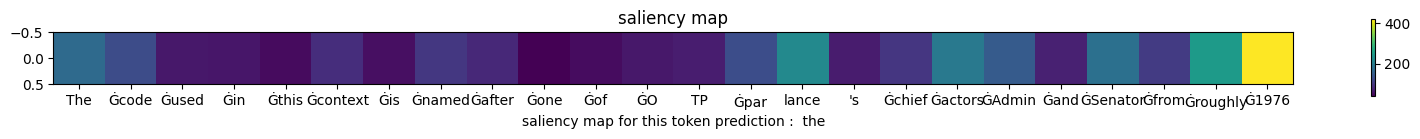

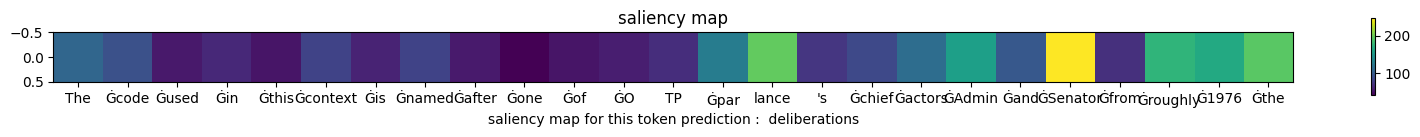

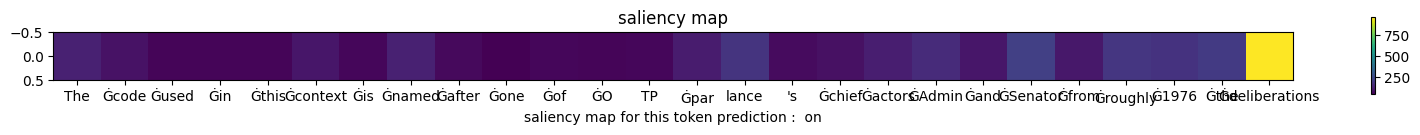

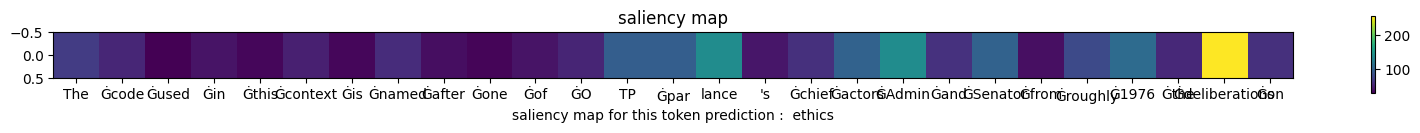

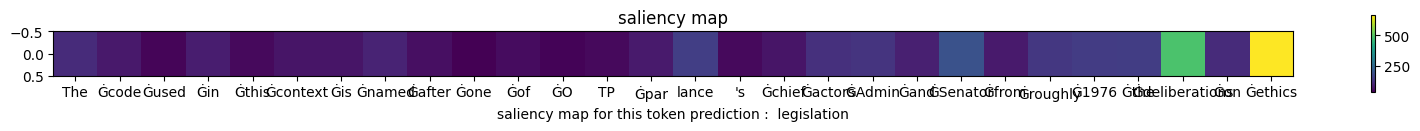

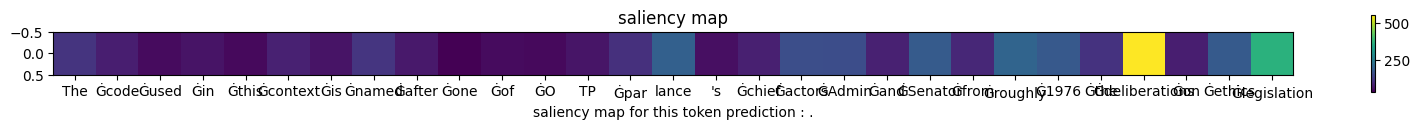

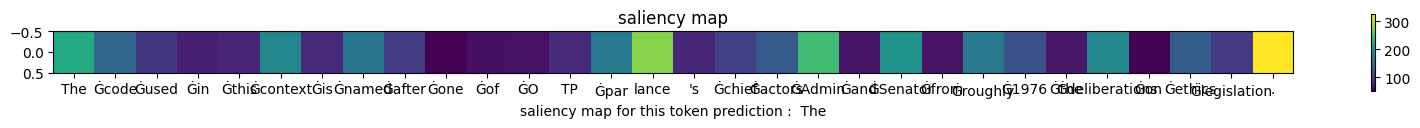

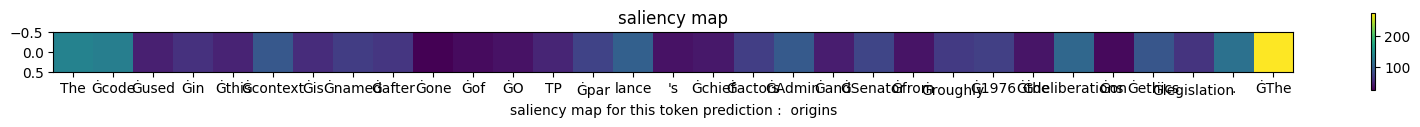

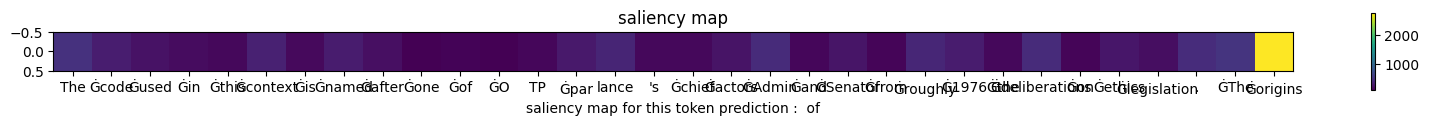

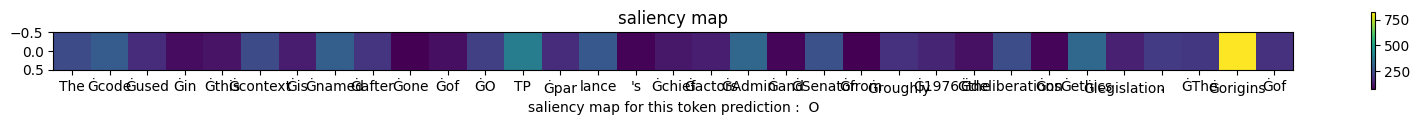

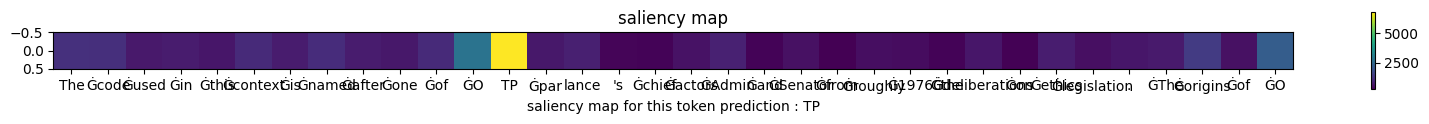

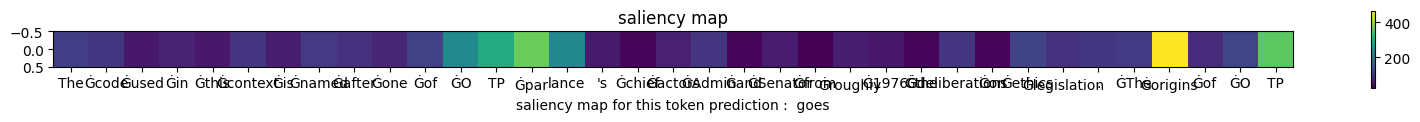

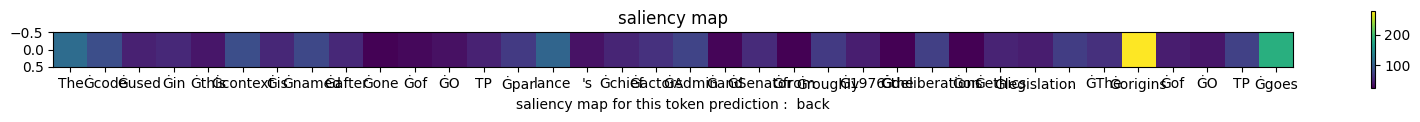

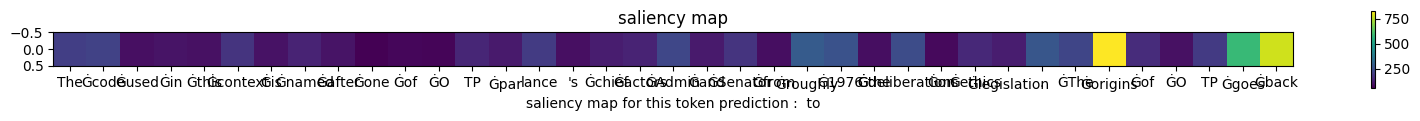

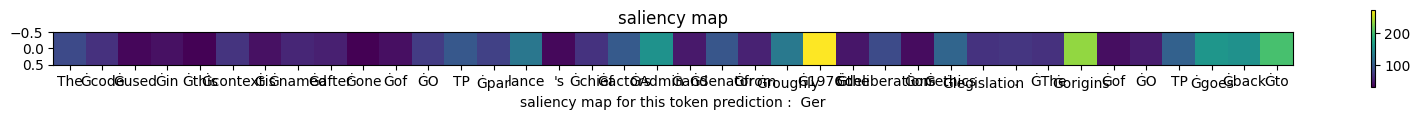

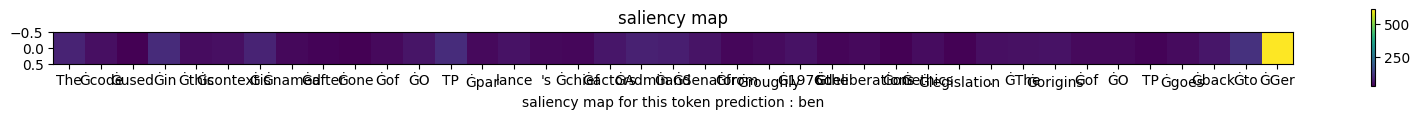

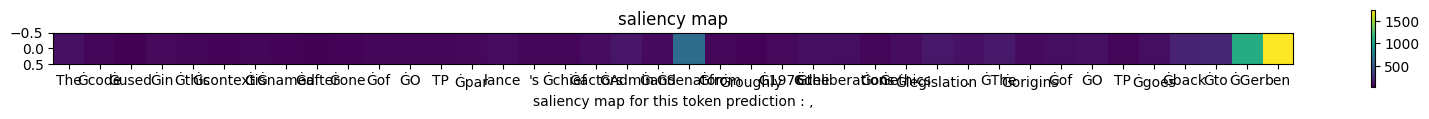

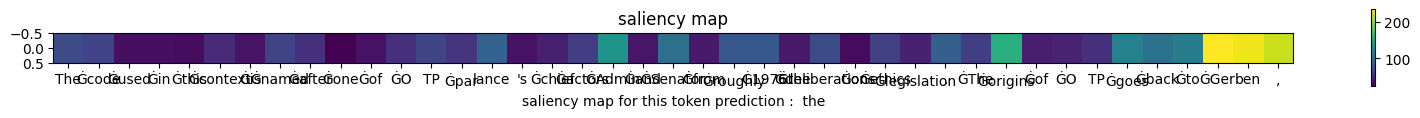

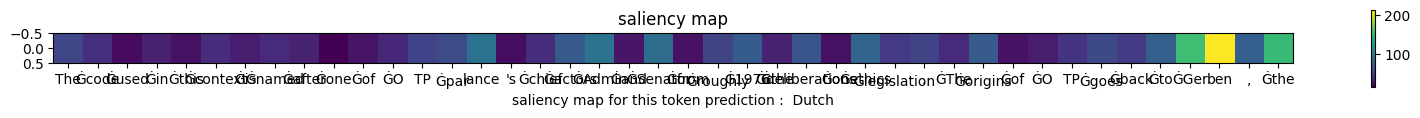

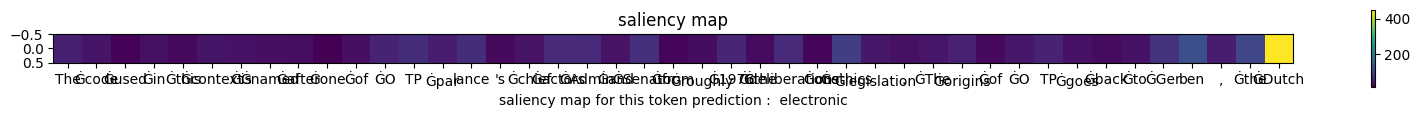

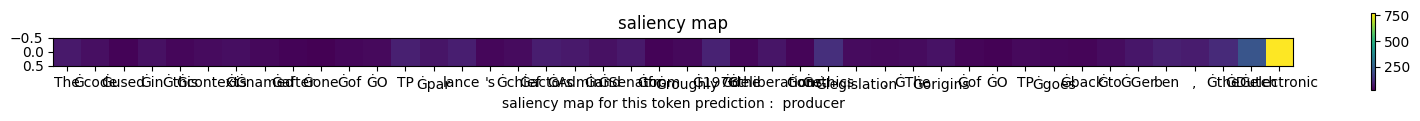

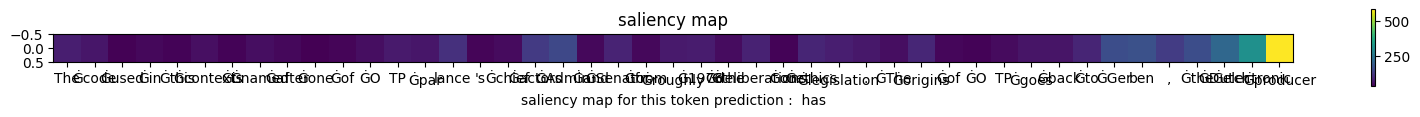

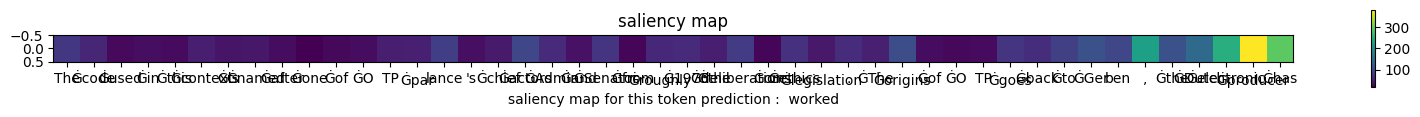

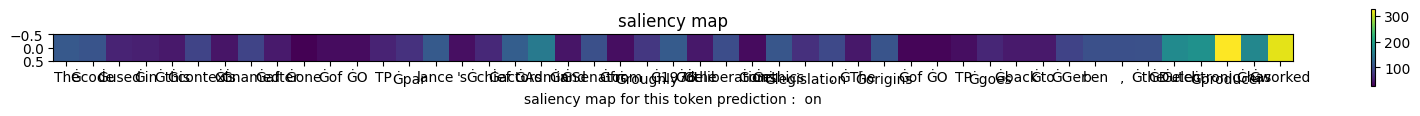

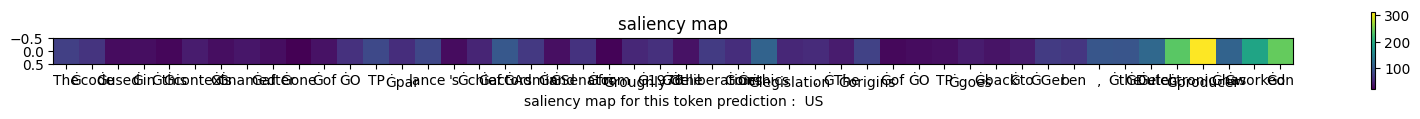

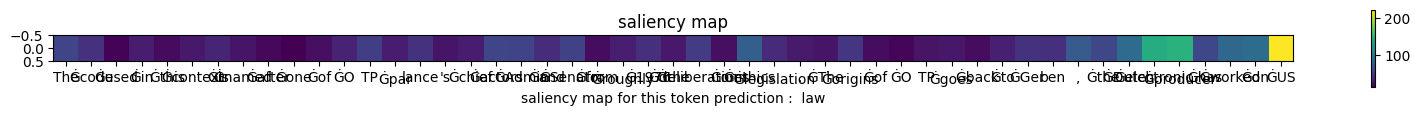

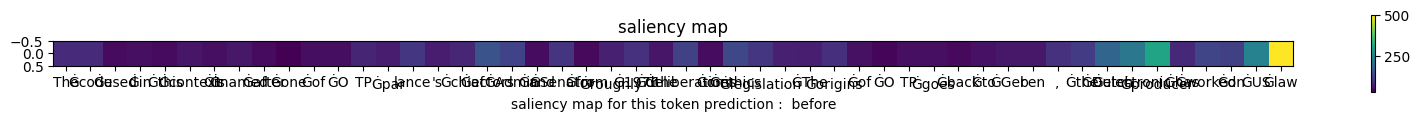

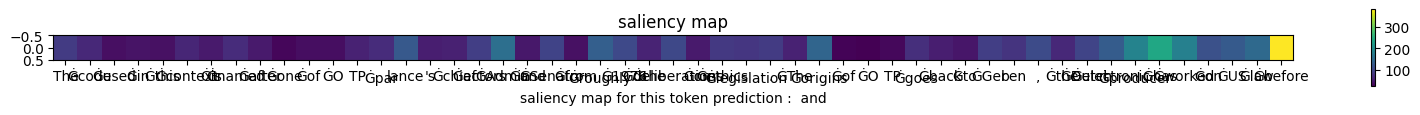

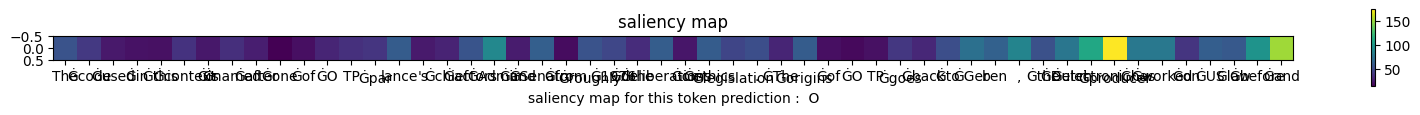

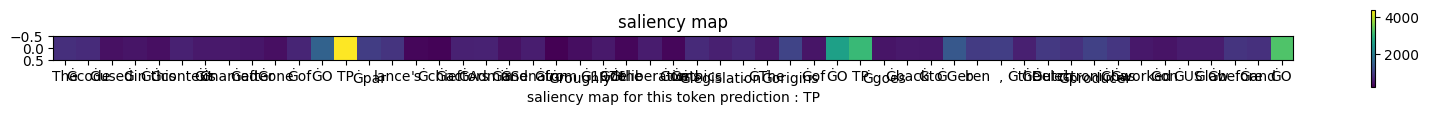

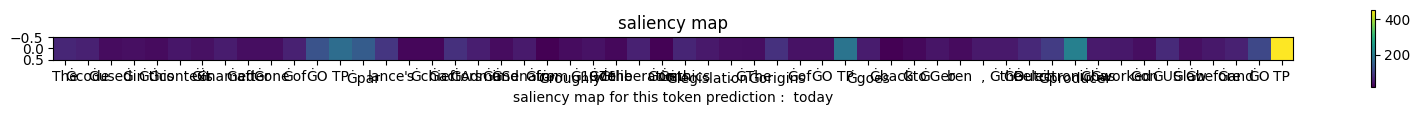

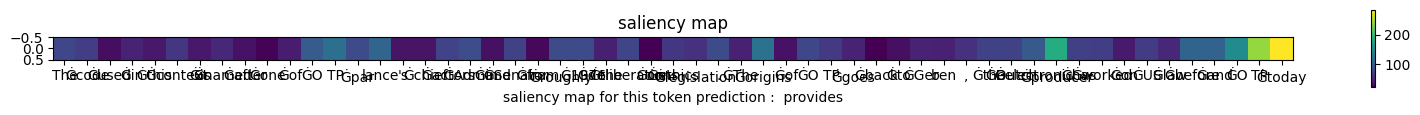

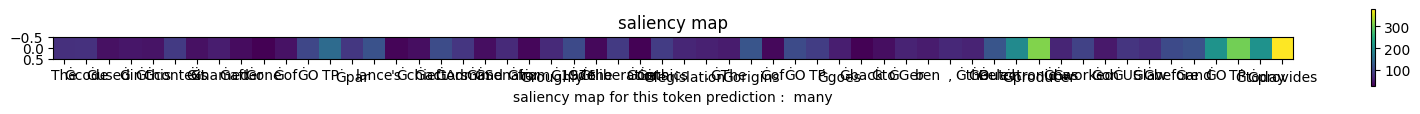

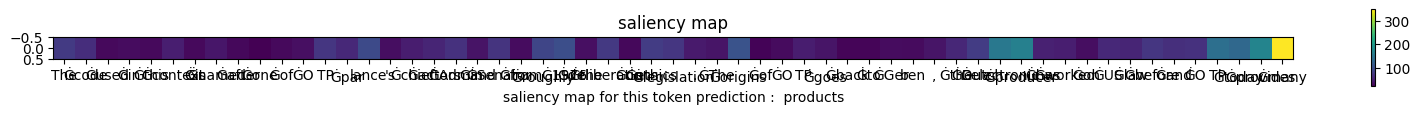

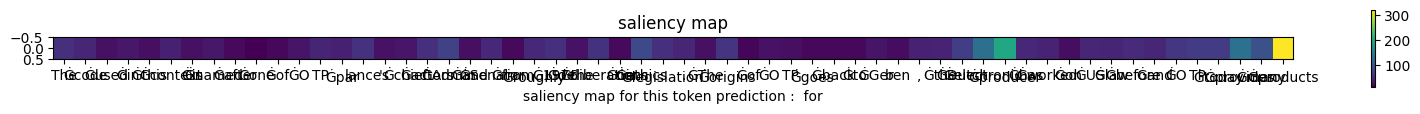

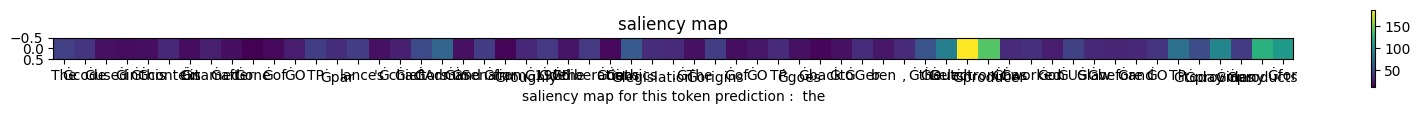

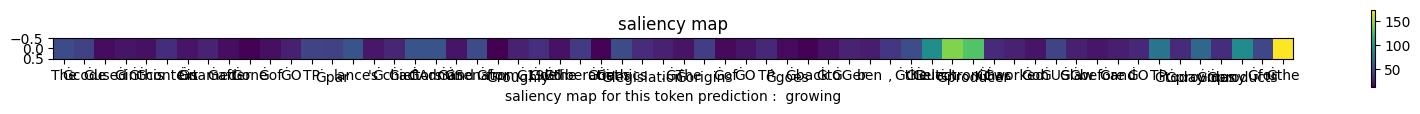

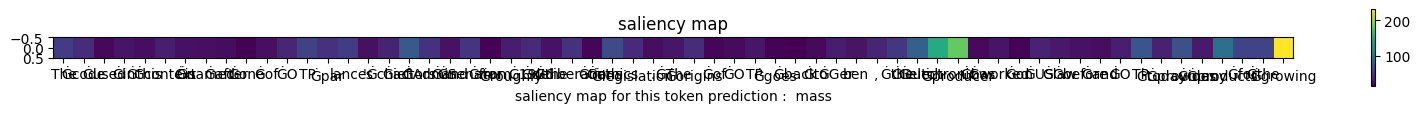

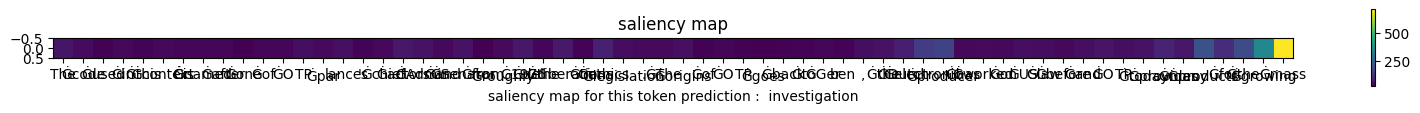

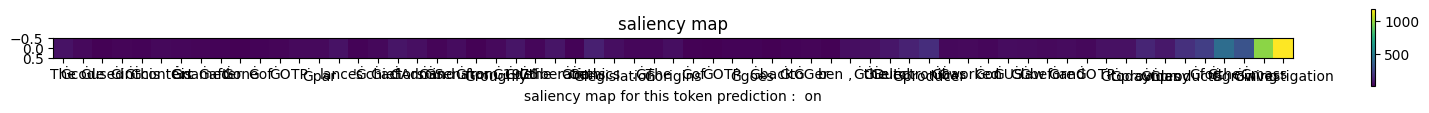

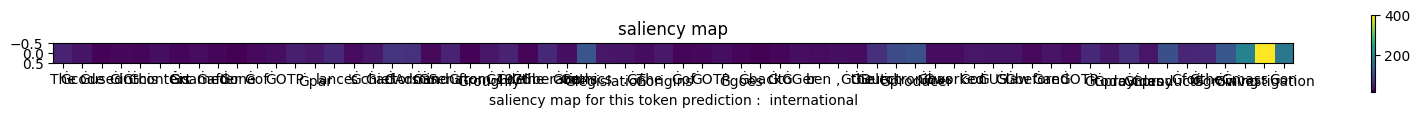

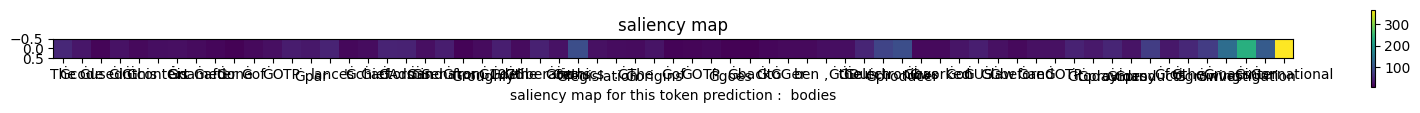

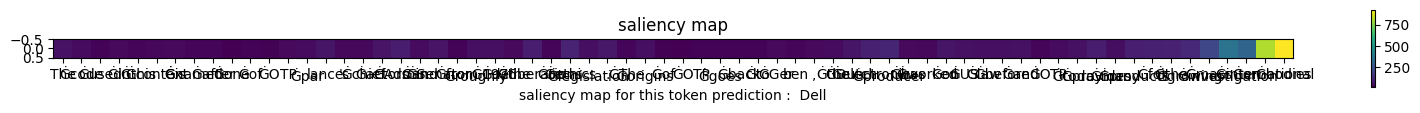

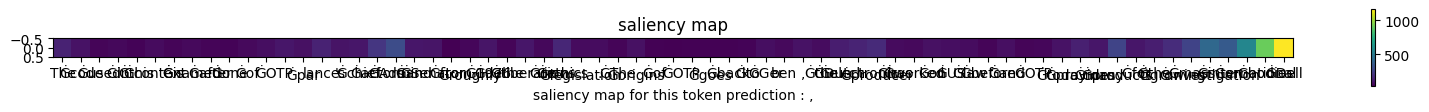

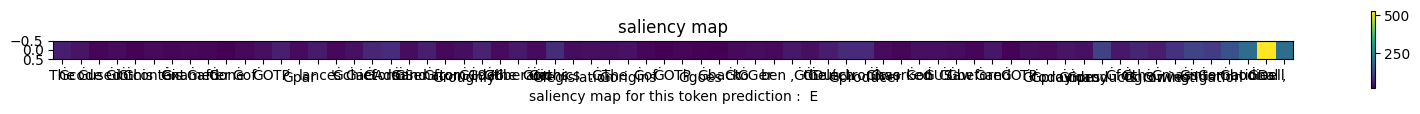

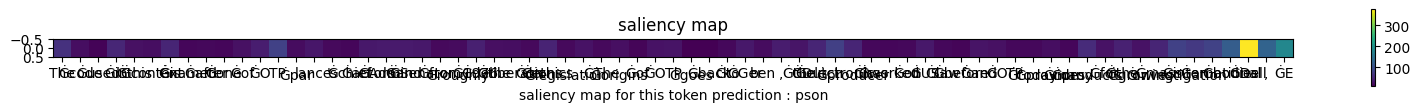

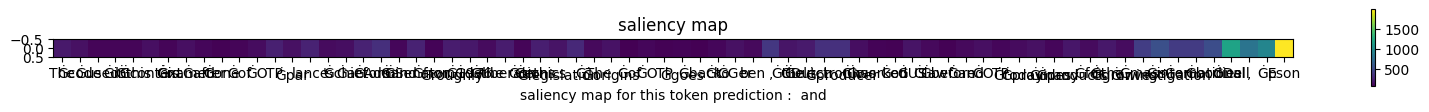

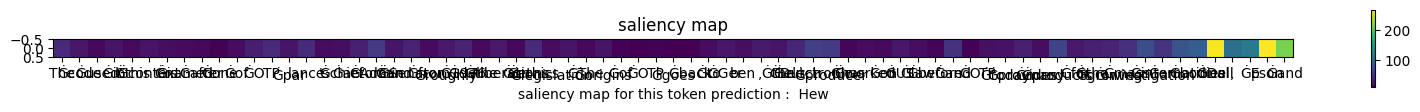

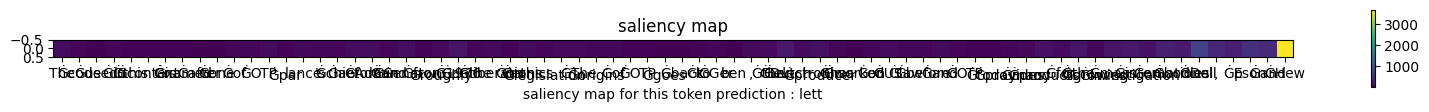

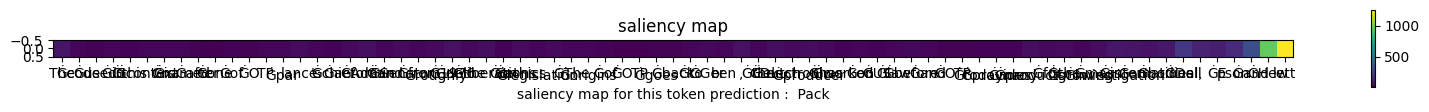

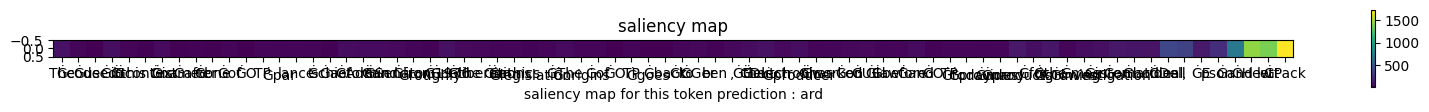

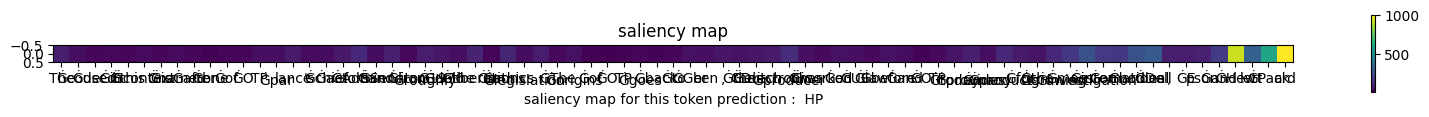

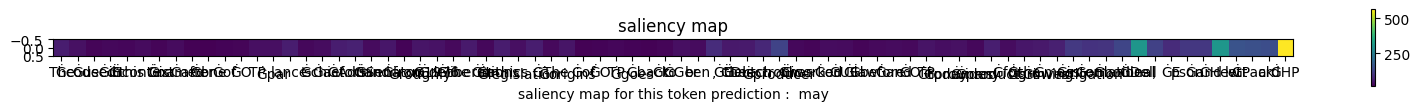

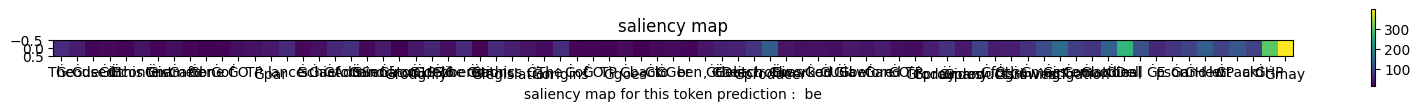

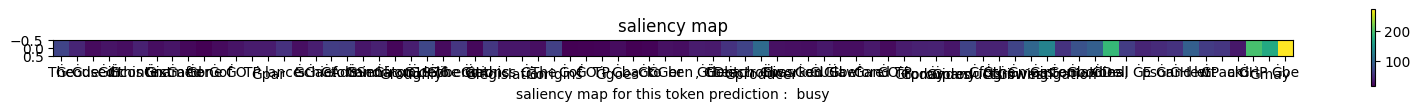

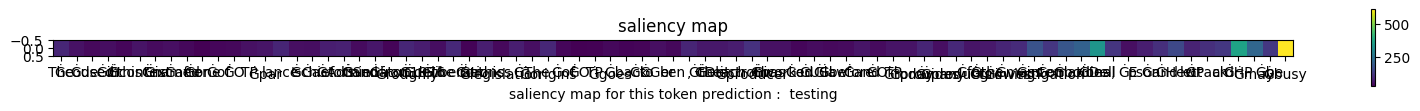

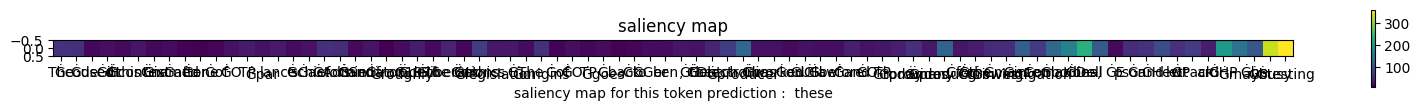

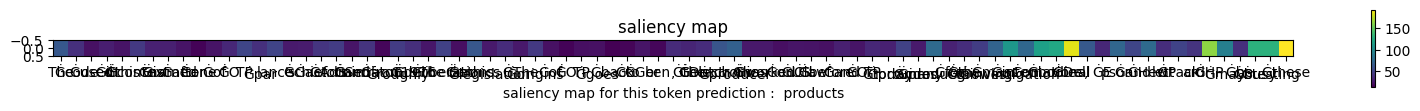

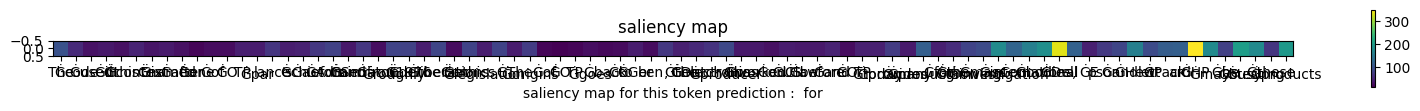

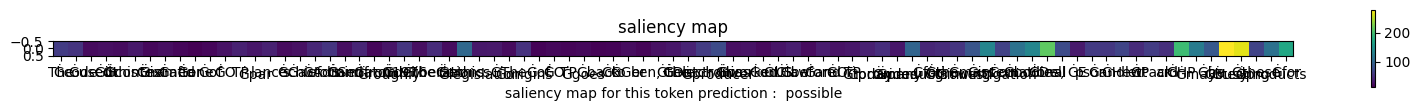

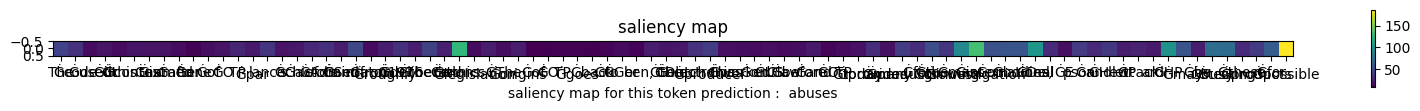

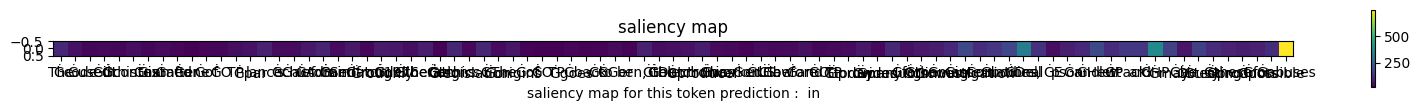

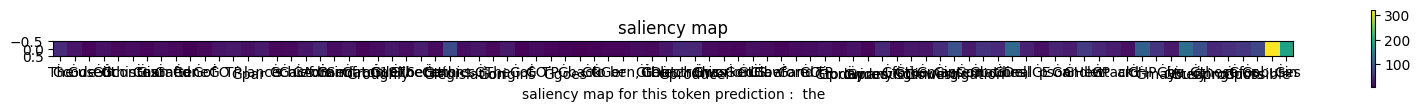

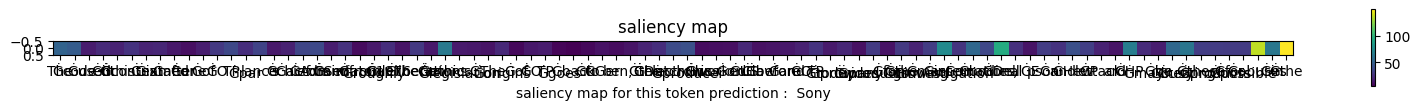

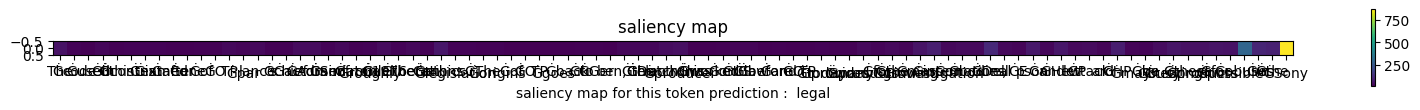

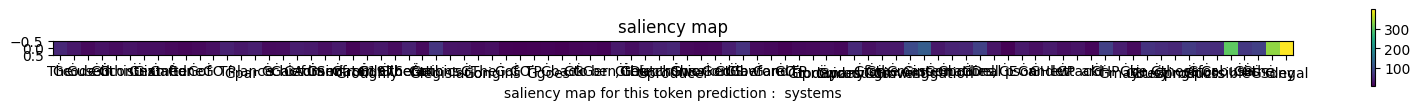

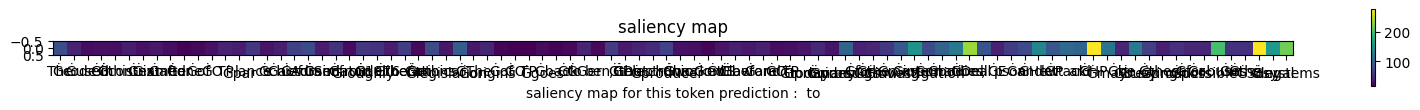

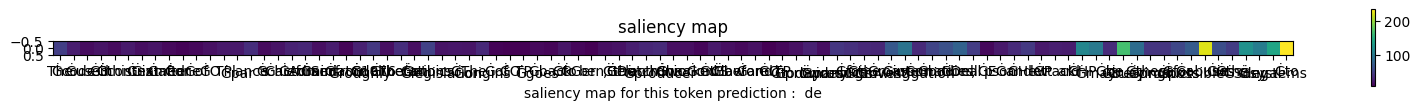

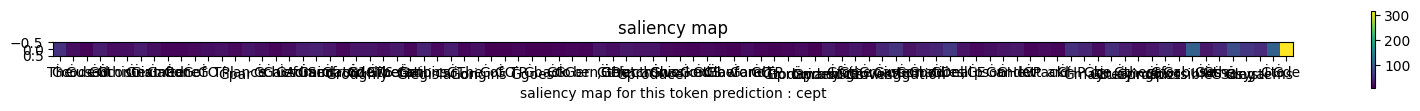

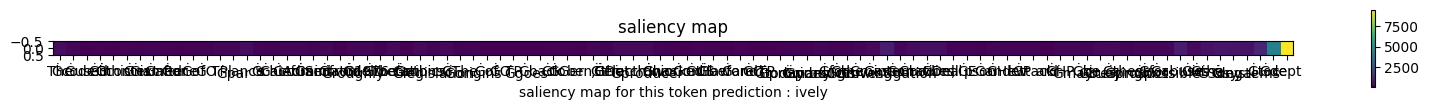

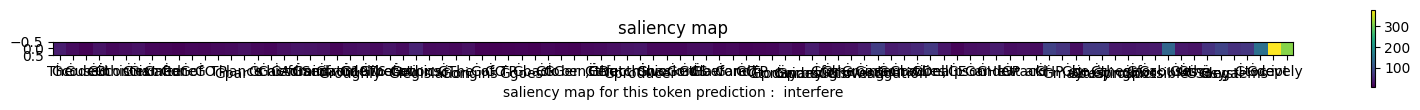

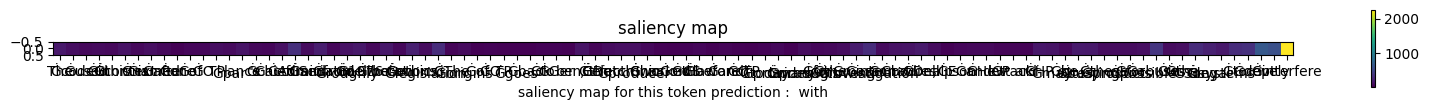

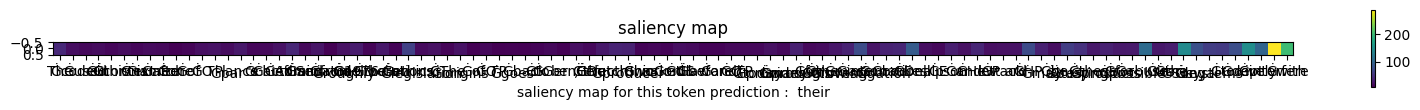

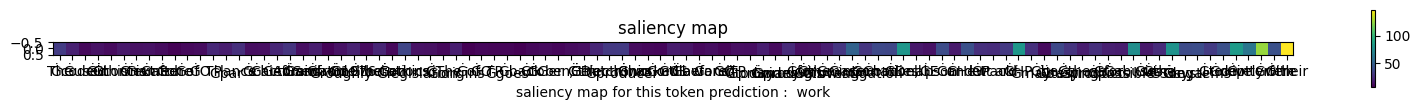

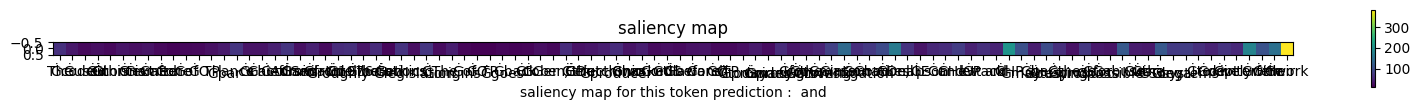

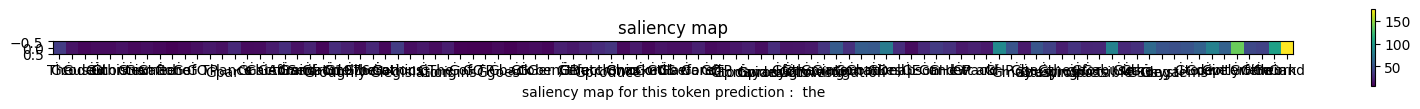

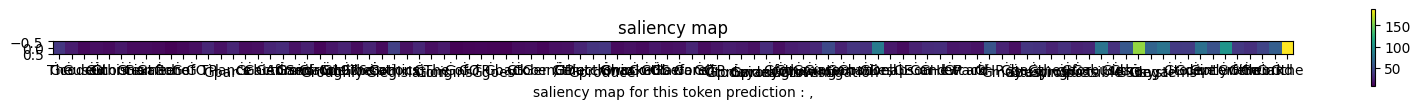

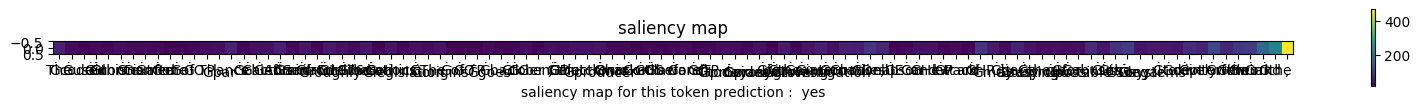

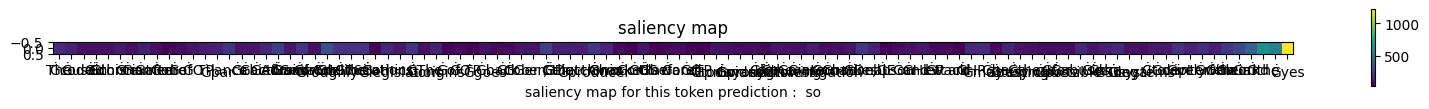

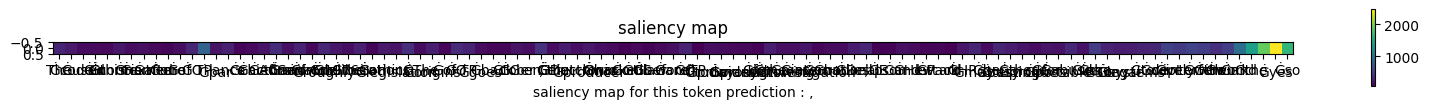

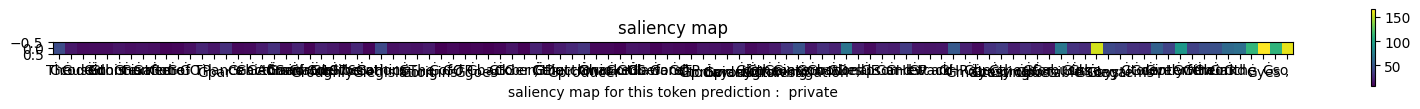

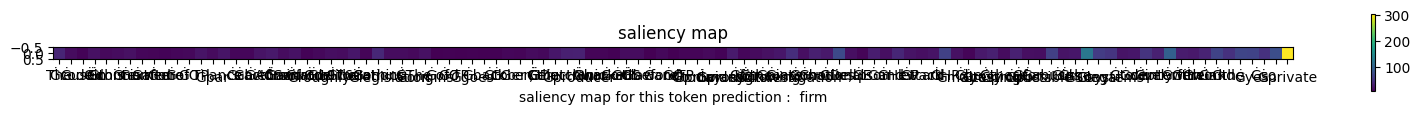

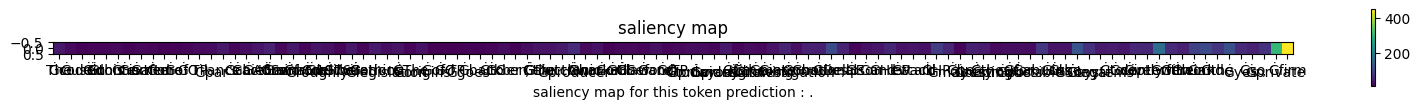

In [4]:
# 4. Forward personnalisé : utilise les embeddings au lieu de input_ids
def forward_func(embeds):
    outputs = model(inputs_embeds=embeds)
    # Prédiction du prochain token (dernier logit)
    return outputs.logits[:, -1, :]  # shape [1, vocab_size]

prompt = "The code used in this context is"
for k in range(100):

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]

    inputs_embeds = model.transformer.wte(input_ids)
    inputs_embeds.requires_grad_()
    # 5. Trouver le token prédicté
    with torch.no_grad():
        out = model(input_ids=input_ids)
        sf = torch.nn.Softmax(1)
        
        #probabilities = probabilities[0].tolist()
        #print(probabilities)
        
        
        
        probabilities = sf(out.logits[:, -1, :])
        pred_token_id = probabilities.multinomial(num_samples=1, replacement=True).item()


        #pred_token_id = torch.argmax(out.logits[:, -1, :], dim=-1).item()
        #print(pred_token_id)
        pred_token = tokenizer.decode([pred_token_id], skip_special_tokens=True)
        #print(f"Token prédit : '{pred_token}'")
        prompt += pred_token

    # 6. Attribution avec Saliency
    saliency = Saliency(forward_func)
    attributions = saliency.attribute(inputs_embeds, target=pred_token_id, abs=True)

    # 7. Affichage des scores par token
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    scores = attributions.sum(dim=-1).squeeze()  # on somme sur les dimensions d'embedding
    saliency_map_plot(scores, tokens,pred_token=pred_token)

        

In [18]:
print(prompt)

The code used in this context is separate from the cards in the following X Games tabletop game (e.g. The Black Knights of Dark Chaos):


Memory for black knights


Mouse and joystick


Windows Graphics MVer 1.5.1 Released: New tested 24.00


No warranty, discounts or special offers made by Badlands Limited. All Materials must be freed from corruptions on the winner's interpretation of the Material. Blackfists can easily lose progress on many other boards and decorations


In [ ]:
scores, tokens



(tensor([21.3558, 31.8937, 11.0285, 27.8907, 17.4590, 32.6019, 28.9326, 75.0482,
         10.4927, 16.3994, 30.0486,  6.3716,  3.7605,  7.0212, 22.8229]),
 ['The',
  'Ġcode',
  'Ġused',
  'Ġin',
  'Ġthis',
  'Ġcontext',
  'Ġis',
  'Ġdeprecated',
  'Ġin',
  'Ġversion',
  'Ġ0',
  '.',
  '9',
  '.',
  'ĊĊ'])

In [210]:
from matplotlib.colorbar import Colorbar

In [29]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
print(outputs)
loss, logits = outputs[:2]
model.get_output_embeddings(logits)
#tokenizer.batch_decode(logits.argmax(), skip_special_tokens=True)


CausalLMOutputWithCrossAttentions(loss=tensor(3.9902, grad_fn=<NllLossBackward0>), logits=tensor([[[ -35.2362,  -35.3266,  -38.9753,  ...,  -44.4645,  -43.9974,
           -36.4580],
         [-112.6171, -114.5832, -116.5725,  ..., -119.0128, -118.8059,
          -111.6917],
         [ -88.7435,  -89.8644,  -93.1977,  ...,  -92.3839,  -96.1783,
           -92.1273],
         [ -85.1646,  -88.3379,  -92.8703,  ...,  -99.8017,  -94.7657,
           -90.9330],
         [-116.7281, -119.3950, -121.7259,  ..., -129.1003, -124.6102,
          -121.6092],
         [ -77.4425,  -80.4463,  -88.0497,  ...,  -96.2564,  -93.6345,
           -84.0666]]], grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-1.2526,  2.3200,  0.1722,  ..., -1.0076, -0.1897,  1.3219],
          [-1.6482,  3.0222,  1.2789,  ..., -0.9078, -1.7395,  2.4237],
          [-1.8892,  2.4222,  2.5229,  ..., -1.4062, -1.9514,  1.7598],
          [-1.4859,  3.7323,  1.5158,  ..., -1.4985, -1.9235,  2.0859],
          [-

TypeError: GPT2LMHeadModel.get_output_embeddings() takes 1 positional argument but 2 were given

In [72]:

question = "I like."
tokens = tokenizer(question,return_tensors="pt")
print(tokens)
print(tokens["attention_mask"])
outputs = model.generate(**tokens, max_new_tokens=100 , do_sample=True, top_k=50, top_p=0.95)

decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
new_in = tokenizer(decoded_outputs,return_tensors="pt")

#model.get_output_embeddings(outputs)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'input_ids': tensor([[ 40, 588,  13]]), 'attention_mask': tensor([[1, 1, 1]])}
tensor([[1, 1, 1]])


In [ ]:
new_in["input_ids"]

torch.Size([1, 37])

In [ ]:

in_embedding = model.get_input_embeddings()


Embedding(50257, 768)

In [83]:
outputs = model(**new_in, output_hidden_states=True ,labels=new_in["input_ids"])


print(outputs)

CausalLMOutputWithCrossAttentions(loss=tensor(2.8743, grad_fn=<NllLossBackward0>), logits=tensor([[[ -39.3084,  -39.0100,  -41.8374,  ...,  -46.9337,  -44.9074,
           -39.5149],
         [ -73.5276,  -72.8394,  -79.3030,  ...,  -80.4989,  -81.8446,
           -76.4412],
         [-129.5338, -128.2919, -130.1002,  ..., -138.8968, -139.3354,
          -123.4873],
         ...,
         [ -68.7578,  -68.5420,  -72.1011,  ...,  -75.0854,  -76.2510,
           -68.3919],
         [ -96.6146, -100.7901, -100.5692,  ..., -109.0760, -107.2313,
           -97.4434],
         [ -97.5167,  -97.5133,  -97.9696,  ..., -109.8812, -111.4926,
           -85.9359]]], grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-1.5577e+00,  2.0585e+00,  1.3060e+00,  ..., -1.3825e+00,
           -6.3336e-01,  1.2624e+00],
          [-2.5532e+00,  2.6298e+00,  1.7484e+00,  ..., -8.9923e-01,
           -1.2752e+00,  1.8641e+00],
          [-2.2638e+00,  2.8894e+00,  1.9155e+00,  ..., -1.8599e-01,
   

In [84]:

# get the hidden states
hidden_states = outputs.hidden_states
logits = outputs.logits


In [91]:
probabilities = torch.nn.functional.softmax(logits[0])
probabilities.shape

/tmp/ipykernel_709904/419503296.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(logits[0])


torch.Size([37, 50257])

In [81]:
model.config

GPT2Config {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "vocab_size": 50257
}

In [80]:
hidden_states[0].shape

torch.Size([1, 37, 768])

In [64]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.logits

In [63]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

In [104]:
saliency = Saliency(model)
saliency


In [105]:
attribution = saliency.attribute(new_in["input_ids"])

AssertionError: Target not provided when necessary, cannot take gradient with respect to multiple outputs.

In [66]:
lig = LayerIntegratedGradients(squad_pos_forward_func, outputs.hidden_states[0][0])

In [ ]:

attributions_start, delta_start = lig.attribute(inputs=new_in["input_ids"],
                                  baselines=ref_input_ids,
                                  additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                  return_convergence_delta=True)


In [8]:
data1

Unnamed: 0  total_scores  occurences
0            0        0.7041       53753
1            1        0.0575       53753
2            2        0.0290       53753
3            3        0.0246       53752
4            4        0.0117       53752
..         ...           ...         ...
56          56        0.0000           1
57          57        0.0000           1
58          58        0.0000           0
59          59        0.0000           0
60          60        0.0000           0

[61 rows x 3 columns]

In [9]:
n=2

1.2333505511999996


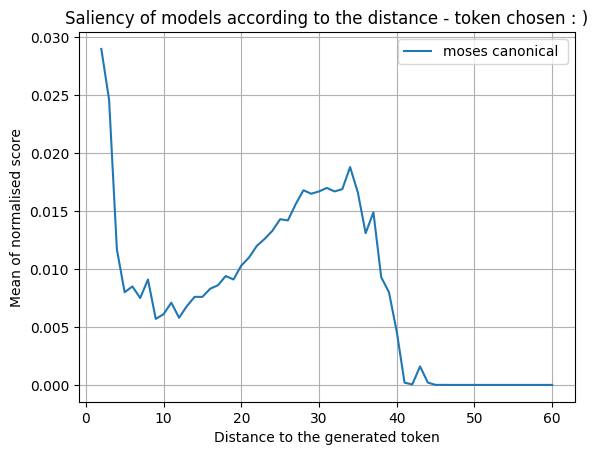

In [13]:

data1 = pd.read_csv("../reports/data/moses_canonical_CL/1/saliency_according_distance_sample_length15000.csv")
total_scores = data1["total_scores"][n:]
somme = 0
for k in data1["total_scores"]:
    somme+=k
print(somme)
x_bins = [n+k for k in range(len(total_scores))]

fig, ax = plt.subplots()
ax.plot(x_bins,total_scores,label="moses canonical ")
ax.set_ylabel('Mean of normalised score')
ax.set_xlabel('Distance to the generated token')
ax.set_title('Saliency of models according to the distance - token chosen : )' )
ax.grid()
ax.legend()


1.1691183599918016


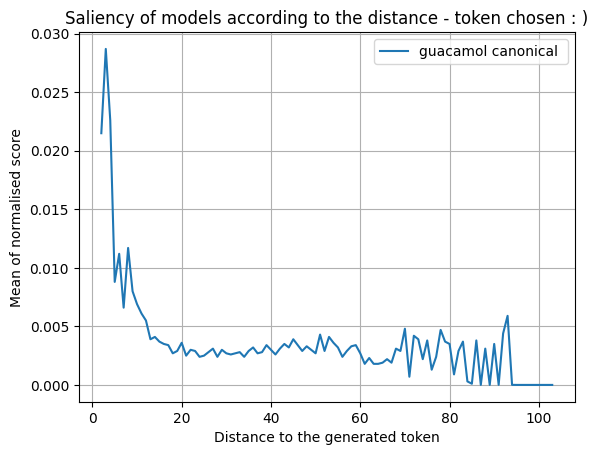

In [12]:

data1 = pd.read_csv("../reports/data/guacamol_canonical_CL/1/saliency_according_distance_sample_length9999.csv")
total_scores = data1["total_scores"][n:]

somme = 0
for k in data1["total_scores"]:
    somme+=k
print(somme)

x_bins = [k+n for k in range(len(total_scores))]

fig, ax = plt.subplots()
ax.plot(x_bins,total_scores,label="guacamol canonical ")
ax.set_ylabel('Mean of normalised score')
ax.set_xlabel('Distance to the generated token')
ax.set_title('Saliency of models according to the distance - token chosen : )' )
ax.grid()
ax.legend()

